<a href="https://colab.research.google.com/github/hemnemne/master_thesis_submission/blob/main/Sentence_Similarity_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up
Set up the Sentence Similarity Classifier.

## Set Parameters
Set and adjust all parameters as needed. 

In [146]:
# are we doing services or faqs or topics?
classifiers = ["services", "faqs", "topics", "topics and services"]
# pick one
classifier = classifiers[0]
# how many user queries do we want to test the model on?
how_many = 1000
# are we removing the stopwords
remove_stopwords = False
# do we want to see the actual output?
wanna_print = False
# "out of k" results
k = 25
# see the GPU
get_hardware_info = False
# are we lower casing everything?
do_lower_case = False
# 0 is the default, so nothing is filtered. set to >1.0 to filter out any services that are not relevant accoarding to d115
boost_value_threshold = .0
# all available pooling modes
pooling_modes = ["cls","mean","max","msl"]
# pick one
pooling_mode = pooling_modes[3] 
# embedding dimension of the representation vectors
dimension = 1024
# random seed
random_state=100
# new k for the topic --> service classifier (for the SERVICES. topics is still the regular k above)
k_topics = 25

# available models
models = ['Sahajtomar/German-semantic', # sota
          'clips/mfaq', 
          'symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli', 
          'deepset/gelectra-large-germanquad', 
          'deepset/gbert-large']
current_model = models[0]

parameters={
    "random_state":random_state,
    "how_many" : how_many,
    "wanna_print":wanna_print, 
    "get_hardware_info" : get_hardware_info,
    "classifier" : classifier,
    "remove_stopwords":remove_stopwords, 
    "k":k, 
    "do_lower_case":do_lower_case,
    "current_model":current_model,
    "boost_value_threshold" : boost_value_threshold,
    "pooling_mode":pooling_mode,
    "dimension":dimension
}

## Load Data
Load the data from Google Drive. Adjust the path accoarding to your directory. 

In [147]:
# load the real dataset

# sync google Drive

from google.colab import drive
drive.mount("/content/drive")

base_path = "/content/drive/MyDrive/Masterarbeit/Colab_Data/LeiKa/"

# where are the files?
file_path_services = base_path + "services.csv"
file_path_faqs = base_path + "faq.csv"
file_path_topics = base_path + "topics.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [148]:
import pandas as pd

# get all services

df_services = pd.read_csv(file_path_services)

if boost_value_threshold > 1.0:
  # and now filter the ones that have a boost value
  df_services = df_services[df_services[[i for i in df_services.columns if i[:4] == "d115"]]["d115DocumentBoostValue"]>boost_value_threshold].sample(frac=1.,random_state=random_state)

# get the faqs

df_faqs = pd.read_csv(file_path_faqs)

# get the topics

df_topics = pd.read_csv(file_path_topics)

## Install Dependencies
We mainly need sentence-transformers and nltk. 

In [149]:
!pip install -U sentence-transformers
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Define Functions
All functions we later use are defined here.

In [150]:
# here come the stopwords

if remove_stopwords:
  import nltk
  from nltk.corpus import stopwords
  nltk.download('stopwords')
  german_stop_words = stopwords.words('german')

In [151]:
def stop_word_removal(x):
  """
  Removes all stopwords from a given string and returns a string without 
  stopwords. 
  """

  token = x.split()
  return ' '.join([w for w in token if not w in german_stop_words])

In [152]:
import torch
from torch import Tensor

def pytorch_cos_sim(a: Tensor, b: Tensor):
    """
    Computes the cosine similarity cos_sim(a[i], b[j]) for all i and j.
    :return: Matrix with res[i][j]  = cos_sim(a[i], b[j])
    """
    return cos_sim(a, b)

def cos_sim(a: Tensor, b: Tensor):
    """
    Computes the cosine similarity cos_sim(a[i], b[j]) for all i and j.
    :return: Matrix with res[i][j]  = cos_sim(a[i], b[j])
    """
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(a)

    if not isinstance(b, torch.Tensor):
        b = torch.tensor(b)

    if len(a.shape) == 1:
        a = a.unsqueeze(0)

    if len(b.shape) == 1:
        b = b.unsqueeze(0)

    a_norm = torch.nn.functional.normalize(a, p=2, dim=1)
    b_norm = torch.nn.functional.normalize(b, p=2, dim=1)
    return torch.mm(a_norm, b_norm.transpose(0, 1))

In [153]:
# this is all for the topics. It maps them to the corresponding services

def get_fibel():
  """
  Gets a dictionary that has all topics as keys and all of their service
  IDs as values. 
  """

  topics_fibel = {} 
  for row in df_topics.iterrows():
    row = row[1]
    category = row["d115Name"]
    services = row["d115Services"]
    if type(services) == float:
      continue
    service_ids = []
    for service in services.split('"'):
      try: 
        service_ids.append(int(service))
      except ValueError:
        continue
    topics_fibel[category] = service_ids
  return topics_fibel

def get_topics_with_services_as_df() -> pd.DataFrame:
  """
  Create a DataFrame with all service IDs in the first column and all of their 
  topics in the second column.
  """
  
  topics_fibel = get_fibel()
  topics_fibel_transposed = []
  for key, value in topics_fibel.items():
    for i in value:
      topics_fibel_transposed.append([i,key])
  return pd.DataFrame(topics_fibel_transposed,columns=["service_id", "topic"])

# Classifier
This is the actual classification. 

## Classify
We first download all models and components and the classify the given user queries. 

In [154]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer(current_model)

In [155]:
# we get the log file

path = "/content/drive/MyDrive/Masterarbeit/Colab_Data/log.csv"
test_data = pd.read_csv(path)

In [156]:
# get rid of the "-" and "NaN" values in the ID column

new_id = []
for i in test_data["selectedID"].to_list():
  try:
    new_id.append(int(i))
  except ValueError:
    new_id.append(0)
test_data["selectedID"] = new_id

In [157]:
# we merge the log (test_data) with the actual services and topics to not only have the selected service -ID-, but also its corresponding -name- and -topic-

if classifier != "faqs":
  test_data = test_data[(test_data["userQuestion"]=="SERVICE_SELECTION_REQUEST") & (test_data["selectedID"]>0)]
  test_data = test_data.merge(df_services, left_on="selectedID", right_on="id")
  test_data = test_data.merge(get_topics_with_services_as_df(), left_on="selectedID", right_on="service_id")

In [158]:
# store the availiable labels in the "labels" list

if classifier == "services":
  labels = df_services["d115Name"].to_list()
  distribution = test_data["d115Name"].value_counts()
elif classifier == "faqs":
  test_data = test_data[test_data["userQuestion"] == "FAQ_ANSWER"]
  labels = df_faqs["faqQuestion"].to_list()
elif classifier == "topics" or classifier == "topics and services":
  distribution = test_data["topic"].value_counts()
  labels = list(get_fibel().keys())

# shuffle the test data
test_data = test_data.sample(frac=1.0,random_state=random_state)

In [159]:
model[0].do_lower_case = do_lower_case

model[1].word_embedding_dimension = dimension

# now, we set the pooling mode. this looks complicated but simply sets the selected one to True and all the rest to False

if pooling_mode == "cls":
  model[1].pooling_mode_cls_token = True
  model[1].pooling_mode_mean_tokens = model[1].pooling_mode_max_tokens = model[1].pooling_mode_mean_sqrt_len_tokens = False
elif pooling_mode == "mean":
  model[1].pooling_mode_mean_tokens = True
  model[1].pooling_mode_cls_token = model[1].pooling_mode_max_tokens = model[1].pooling_mode_mean_sqrt_len_tokens = False
elif pooling_mode == "max":
  model[1].pooling_mode_max_tokens = True
  model[1].pooling_mode_cls_token = model[1].pooling_mode_mean_tokens = model[1].pooling_mode_mean_sqrt_len_tokens = False
elif pooling_mode == "msl":
  model[1].pooling_mode_mean_sqrt_len_tokens = True
  model[1].pooling_mode_cls_token = model[1].pooling_mode_mean_tokens = model[1].pooling_mode_max_tokens = False
else:
  raise ValueError(f"The pooling mode {pooling_mode} is not deefined correctly.")

print(model[0])
print(model[1])

Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': True})


In [160]:
print(f"There are {len(labels)} possible labels in total.")

There are 881 possible labels in total.


In [161]:
labels_embedded = model.encode(labels, convert_to_tensor=True)

In [162]:
# if we are looking for the topic fist and then the service

# if classifier == "topics and services":
topic_labels_embedded = {}
fibel = get_fibel()

def get_service_name_from_id(id:int):
  """
  Get the service name from its id.
  """

  for i in df_services.iterrows():
    if i[1]["id"] == id:
      return i[1]["d115Name"]


def get_service_names_from_topic_name(topic:str):
  """
  For a topic (as str) this gets the list of str of all services.
  """

  return [get_service_name_from_id(i) for i in fibel[topic]]

for topic in list(fibel.keys()):
  topic_labels_embedded[topic] = model.encode(get_service_names_from_topic_name(topic), convert_to_tensor=True)

In [163]:
hits = 0

invest_len_df = pd.DataFrame(columns=["query", "length", "correct"])

for index,row in test_data.iloc[:how_many].iterrows():
  question = row["sessionID"]
  if remove_stopwords:
    question = stop_word_removal(question)
  query_embedded = model.encode(question, convert_to_tensor=True)
  if classifier == "services" or classifier == "topics and services":
    true_answer = row["d115Name"]
  elif classifier == "topics":
    true_answer = row["topic"]
  elif classifier == "faqs":
    # for the FAQs we use a different csv we pull the data from 
    # (find the code next block)
    break
  cosine_scores = util.pytorch_cos_sim(query_embedded, labels_embedded)
  scores = cosine_scores[0].tolist()
  score_df = pd.DataFrame(columns=["service", "score"])
  score_df["service"] = labels
  score_df["score"] = scores
  ranking = score_df.sort_values(by="score",ascending=False)
  mvps = ranking.iloc[:k]

  if classifier == "topics and services":

    # this is if we not only classify topics, but also their services
    
    servs = pd.DataFrame(columns=["service","score"])
    for i in mvps["service"].to_list():
      cosine_scores = util.pytorch_cos_sim(query_embedded, topic_labels_embedded[i])
      scores = cosine_scores[0].tolist()
      score_df = pd.DataFrame(columns=["service", "score"])
      score_df["service"] = get_service_names_from_topic_name(i)
      score_df["score"] = scores
      ranking = score_df.sort_values(by="score",ascending=False)
      mvps_for_each_topic = ranking.iloc[:k]
      servs = servs.append(mvps_for_each_topic)
    servs = servs.sort_values(by="score",ascending=False)

    mvps = servs.iloc[:k_topics]

  invest_len_dict = {}
  invest_len_dict["query"] = question
  invest_len_dict["length"] = len(question)
  if true_answer in mvps['service'].to_list() and classifier != "faqs":
    # increase the hits
    hits += 1
    # and catch the query to investigate the length correlation
    invest_len_dict["correct"] = 1
  else:
    invest_len_dict["correct"] = 0
  invest_len_df = invest_len_df.append(pd.Series(invest_len_dict),ignore_index=True)
  if wanna_print:
    print(question)
    print(true_answer)
    print(mvps)
    print("\n\n\n")

if classifier != "faqs":
  score = (hits/how_many)*100

In [164]:
# this is the new data
# it does almost the same as the loop(s) before, using the new FAQ data instead

if classifier == "faqs":

  faq_path = "/content/drive/MyDrive/Masterarbeit/Colab_Data/faqClicks.csv"
  new_faq_test_data = pd.read_csv(faq_path).drop_duplicates(subset=["ursprüngliche Frage"]).sample(frac=1.,random_state=random_state)
  queries = new_faq_test_data["ursprüngliche Frage"].to_list()
  true_answers = new_faq_test_data["angeklickte FAQ-Frage"].to_list()
  possible_answers = [i for i in new_faq_test_data["angeklickte FAQ-Frage"].unique()]

  answers_embedded = model.encode(possible_answers, convert_to_tensor=True)
  hits = 0

  for idx,value in enumerate(queries[:how_many]):
    if remove_stopwords:
      question = stop_word_removal(value)
    query_embedded = model.encode(question, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(query_embedded, answers_embedded)
    scores = cosine_scores[0].tolist()

    score_df = pd.DataFrame(columns=["service", "score"])
    score_df["service"] = possible_answers
    score_df["score"] = scores
    ranking = score_df.sort_values(by="score",ascending=False)
    mvps = ranking.iloc[:k]
    if true_answers[idx] in mvps["service"].to_list():
      if wanna_print:
        print("Correct:\n")
      hits += 1
    else:
      if wanna_print:
        print("Wrong:\n")
      pass
    if wanna_print:
      print(question)
      print(true_answers[idx])
      print(mvps)
      print("\n\n")
  score = (hits/how_many)*100

## Evaluate
Now we get the scores and save them as .csv.
Adjust the path accoarding to your directory. 


In [165]:
# add the score
parameters["score"] = score
# cast to series
results_row = pd.Series(parameters)

In [166]:
# show the results
results_row

random_state                                    100
how_many                                       1000
wanna_print                                   False
get_hardware_info                             False
classifier                                 services
remove_stopwords                              False
k                                                25
do_lower_case                                 False
current_model            Sahajtomar/German-semantic
boost_value_threshold                           0.0
pooling_mode                                    msl
dimension                                      1024
score                                          85.6
dtype: object

In [167]:
# save to frame
results_path = "/content/drive/MyDrive/Masterarbeit/Colab_Data/results_SCC.csv"
frame = pd.read_csv(results_path,index_col=False)
frame = frame.append(results_row,ignore_index=True)
frame.to_csv(results_path, index=False)

## Investigate
If needed, we can investigate different aspects from the thesis. 

Anmeldung einer Wohnung:11.78
Parkausweis für Anwohner beantragen, umschreiben oder Verlust melden:5.28
Personalausweis beantragen:4.43
Führungszeugnis beantragen:4.14
Reisepass beantragen:3.12
Meldebescheinigung beantragen:2.63
Belehrung nach dem Infektionsschutzgesetz - Bescheinigung:2.33
Änderung/Wechsel der Hauptwohnung:2.17
Kinderreisepass beantragen / verlängern / aktualisieren:2.08
Führerschein - Ausstellung eines Internationalen Führerscheins:1.85
berlinpass beantragen:1.82
Eheschließung - Durchführung:1.81
Führerschein - Ersatzführerschein nach Verlust oder Diebstahl beantragen:1.77
Geburtsurkunde beantragen:1.56
Einbürgerung:1.56
Eheschließung - ohne Auslandsbeteiligung - Auskunft, Beratung und Anmeldung:1.55
Abmeldung einer Wohnung:1.55
Elterngeld beantragen:1.48
Kraftfahrzeug außer Betrieb setzen (Kfz abmelden):1.45
Vaterschaftsanerkennung:1.32
Eheschließung - mit Auslandsbeteiligung - Auskunft, Beratung und Anmeldung:1.17
Fundsachen - Verlorene Sachen zurückbekommen:1.15
V

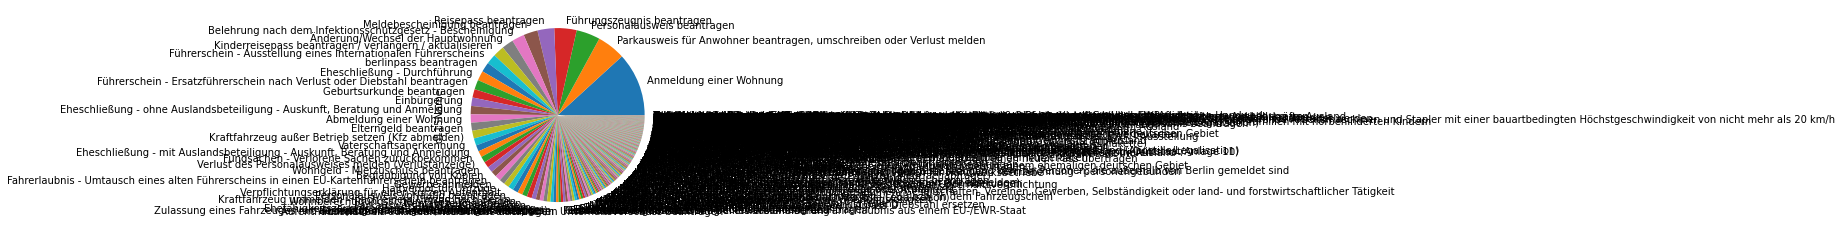

In [168]:
# get the service distribution for Section 5.4.4
# set to true if you want to investigare

investigate_distr = True

if investigate_distr and classifier=="services":
  threshold = 10
  distr = test_data["d115Name"].value_counts()
  n = sum(distr.to_list())
  distr_dict = dict(distr)
  counter_irrelevant = 0
  for key,value in distr_dict.items():
    if value < threshold:
      counter_irrelevant += 1
    print(f"{key}:{round((value/n)*100,2)}")
  print("\n\n")
  print(f"{counter_irrelevant} services out of {len(distr.index.to_list())} selected services have been selected less than {threshold} times\n\n")
  distr.plot(kind="pie")

In [169]:
# investigate the correlation between the sequence length and correct classifications
# set to true if you want to investigare

invest_len = True

if invest_len and classifier=="services":

  print(invest_len_df)
  correlation = invest_len_df["correct"].astype(float).corr(invest_len_df["length"].astype(float))

  print(f"The correlation between the correctness of the SCC and the length of the user query is {round(correlation,4)}")

                                                 query length correct
0      Ich brauche eine internationale Geburtsurkunde.     47       1
1    brauche ich für eine Wohnungsanmeldung einen T...     52       1
2    Ich mochte die Anmeldung machen. Muss ich ein ...     65       1
3                     Ich brauche ein Führungszeugnis      32       1
4                                   Meldebescheinigung     18       1
..                                                 ...    ...     ...
995                                          Reisepass      9       1
996                      Ummeldung einer Wohnanschrift     29       1
997  Ich brauche einen neuen Personalausweis, ich r...    244       1
998  Wann wird der unterhaltsvorschuss dieses Mal ü...     56       1
999             Gebühren für pass und Personalausweis?     38       1

[1000 rows x 3 columns]
The correlation between the correctness of the SCC and the length of the user query is -0.0308
